**This notebook explains the Grounding DINO model prediction**
* By passing image and the list of classes, the model predicts the bounding box if that class is present in the image.

In [1]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 391, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 391 (delta 22), reused 33 (delta 13), pack-reused 336
Receiving objects: 100% (391/391), 12.86 MiB | 31.73 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [2]:
cd GroundingDINO/

/content/GroundingDINO


In [3]:
!pip install -q -e .

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.9 MB/s eta 0:00:00


In [4]:
# download model
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

In [5]:
#Sample Image
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg

--2023-07-20 08:44:39--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271475 (265K) [image/jpeg]
Saving to: ‘images/truck.jpg’

truck.jpg           100%[===================>] 265.11K  --.-KB/s    in 0.02s   

2023-07-20 08:44:40 (14.3 MB/s) - ‘images/truck.jpg’ saved [271475/271475]



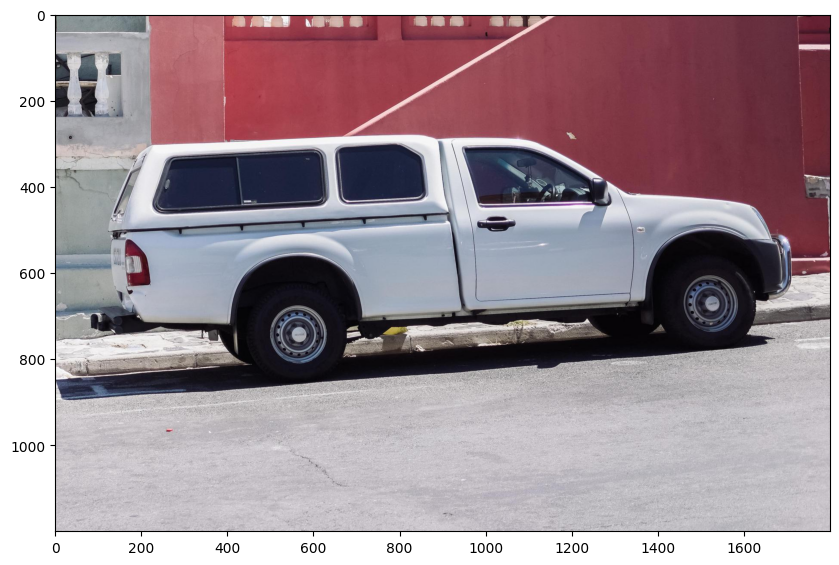

In [12]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [8]:
from groundingdino.util.inference import Model
import cv2
import glob
GROUNDING_DINO_CONFIG_PATH = "groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "groundingdino_swint_ogc.pth"
grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH,
                                     model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [17]:
def enhance_class_name(class_names):
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

def draw_bounding_box(image, bbox, color=(0, 255, 0), thickness=2):
    x1, y1, x2, y2 = bbox
    cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)

In [10]:
CLASSES = ["car", "wheel"]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:881: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


predicted class car : predicted bbox [85.32666015625, 268.5503845214844, 1717.1435546875, 853.2872314453125]
predicted class wheel : predicted bbox [433.0611877441406, 619.9999389648438, 679.3359985351562, 852.8412475585938]


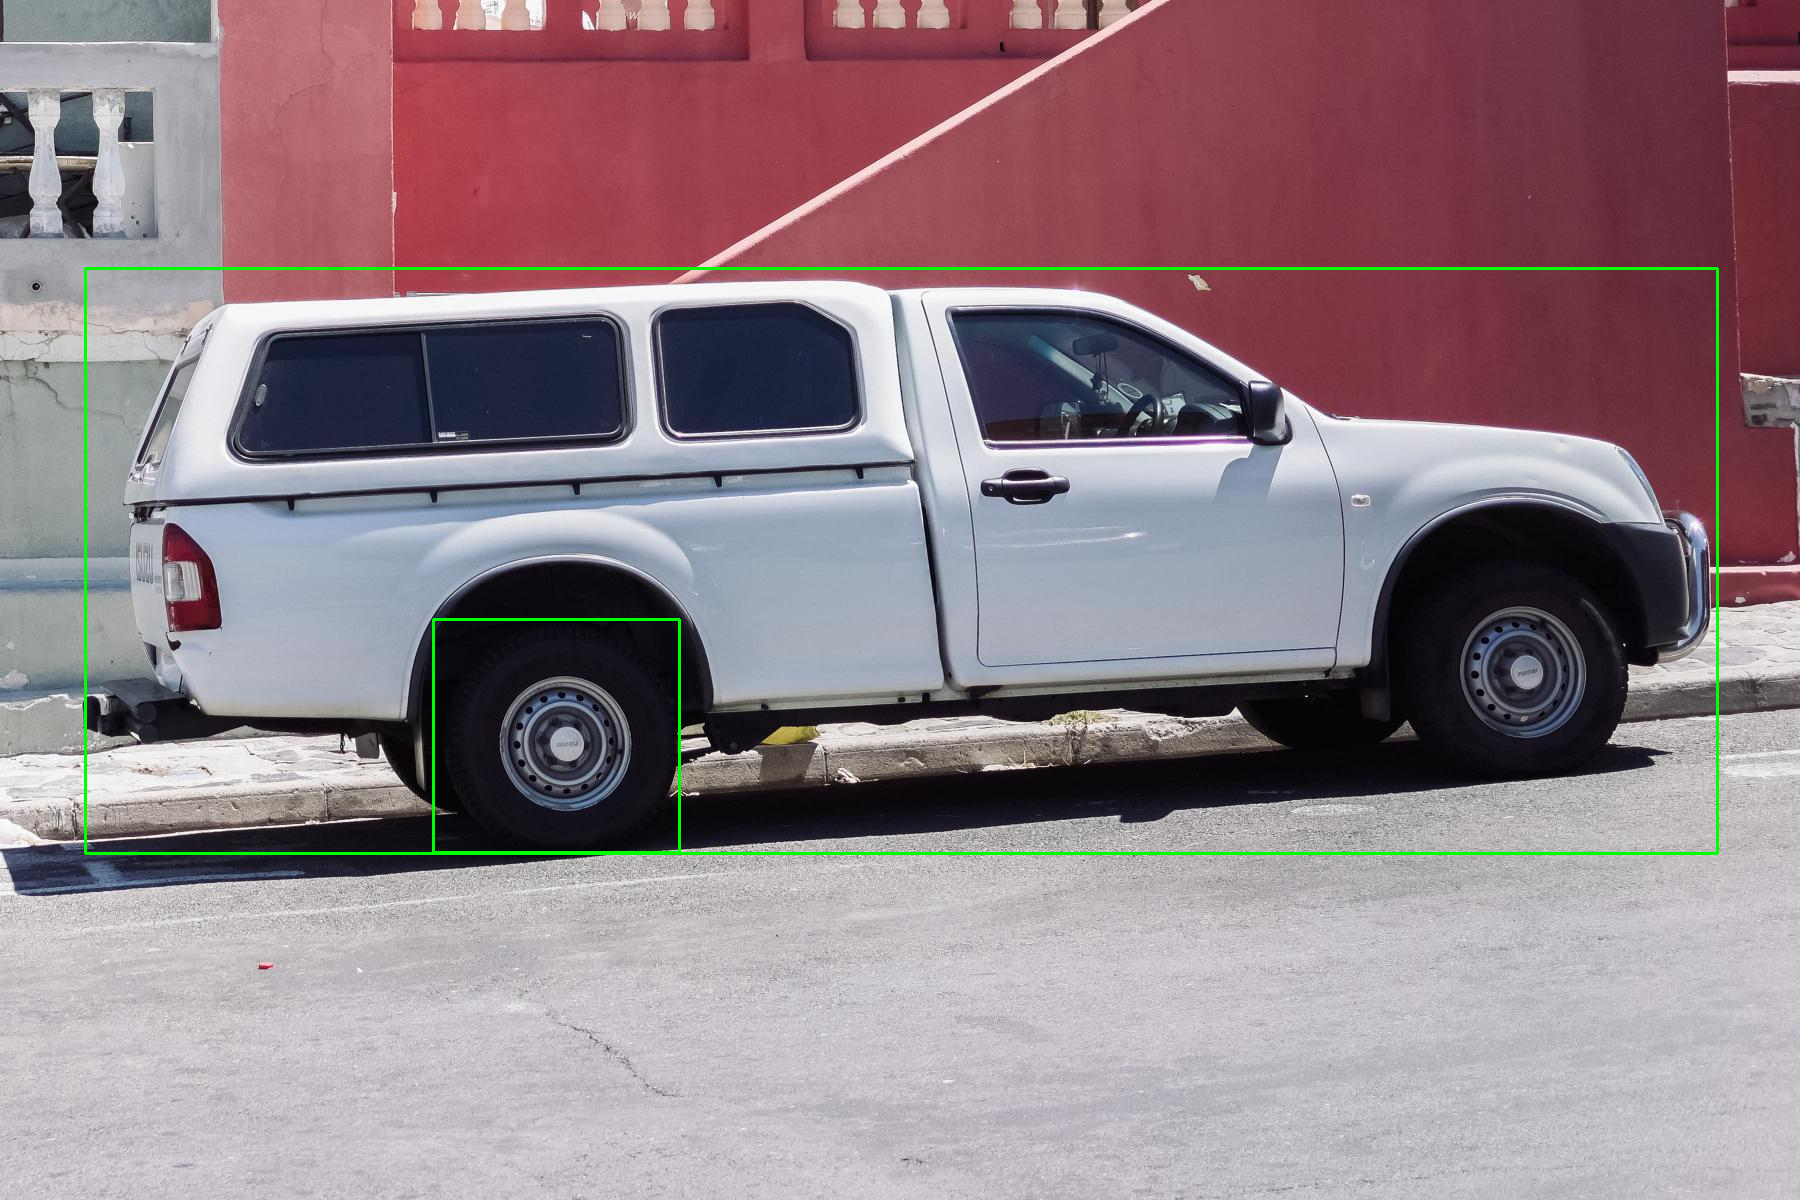

In [18]:
BOX_TRESHOLD = 0.40
TEXT_TRESHOLD = 0.25
SOURCE_IMAGE_PATH = "images/truck.jpg"
tmp = SOURCE_IMAGE_PATH.split("/")
extension = tmp[len(tmp) - 1].split(".")[1]
name = tmp[len(tmp) - 1].split(".")[0]
image = cv2.imread(SOURCE_IMAGE_PATH)
detections = grounding_dino_model.predict_with_classes(
              image=image,
              classes= enhance_class_name(class_names=CLASSES),
              box_threshold=BOX_TRESHOLD,
              text_threshold=TEXT_TRESHOLD)

bboxes = detections.xyxy.tolist()
classes = detections.class_id.tolist()
for a, b in enumerate(bboxes):
  x1, y1, x2, y2 = b
  class_name = CLASSES[a]
  print(f"predicted class {class_name} : predicted bbox {b}")
  bb = [int(num) for num in b]
  draw_bounding_box(image, bb)
cv2_imshow(image)